In [18]:
library(ggplot2)
library(tidyverse)
library(vcfR) # reading vcf files 
library(scales) # for scaling
library(cowplot) # plotting two figures side by side

In [19]:
# Utility functions
asinh_trans <- function(){
  trans_new(name = 'asinh', transform = function(x) asinh(x), 
            inverse = function(x) sinh(x))
}
     
read_vcf <- function(vcf_file) {
    vcf <- read.vcfR( vcf_file, verbose = FALSE )  
    samplename = colnames(vcf@gt)[2]
    values = vcfR2tidy(vcf, 
          info_only = TRUE,
          info_fields = c("SVLEN", "IDLIST"),
          verbose = FALSE)  
    values$fix = values$fix %>% mutate(SVLEN=as.integer(SVLEN))
    data = data.frame(as.numeric(values$fix$SVLEN))
    names(data) = "size"
    data$sample = as.factor(samplename)
    return(data)
}

             
dualplotmulti <- function(data, adjust=4) {
   negative = subset(data, size<0, select=c(size, sample))
   p1 = ggplot() +
           geom_density(data = negative, aes(x=size, y=..density.., color=sample), adjust=adjust, alpha=0.3, bw=0.02, fill=NA) +
           theme_bw() +
           scale_x_continuous(limits=c(-100000,-50), 
                              breaks=c(-100000,-10000,-100, -50),
                              label=c('-100kb','-10kb','-100bp',''),
                              trans="asinh",
                              expand = expansion(add = 0.1)) + 
           theme(plot.margin = unit(c(1,0,1,1), "cm")) +
           theme(legend.position = "none") +
           labs(x="DEL")  
   positive = subset(data, size>0, select=c(size, sample))
   p2 = ggplot() +
            geom_density(data = positive, aes(x=size, y=..density.., color=sample), adjust=adjust, alpha=0.3, bw=0.02, fill=NA) +
            theme_bw() +
            scale_x_continuous(limits=c(50,100000), 
                                breaks=c(50, 100, 10000, 100000),
                                label=c('', '100bp','10kb','100kb'),
                                trans="asinh",
                                expand = expansion(add = 0.1)) + 
            theme(plot.margin = unit(c(1,1,1,0), "cm"))  +
            scale_y_continuous(position = "right") +
            labs(x="INS")
    return(list("left"=p1, "right"=p2))
}                   

#### Using an intermediate file
```bash
{
printf "chrom\tpos\tsvtype\tsize\n"
bcftools query -i 'INFO/SVTYPE=="DEL" || INFO/SVTYPE=="INS"' -f "%CHROM\t%POS\t%INFO/SVTYPE\t%INFO/SVLEN\n" test.vcf.gz 
} > test_variantsizes.tsv
```

In [20]:
tsvfile="test_variantsizes.tsv"

In [23]:
df = read_tsv(tsvfile, col_types = list(svtype=col_factor(c("DEL", "INS")), chrom=col_character()))
#df$size = abs(df$size)

ERROR: Error in getLevels(domain, NULL, levels, ordered): l'argument "domain" est manquant, avec aucune valeur par défaut


In [12]:
df = read_tsv(tsvfile)

Rows: 951 Columns: 4

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): svtype
dbl (3): chrom, pos, size


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



Warning message in self$trans$transform(x):
“Production de NaN”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 479 rows containing non-finite values (stat_bin).”


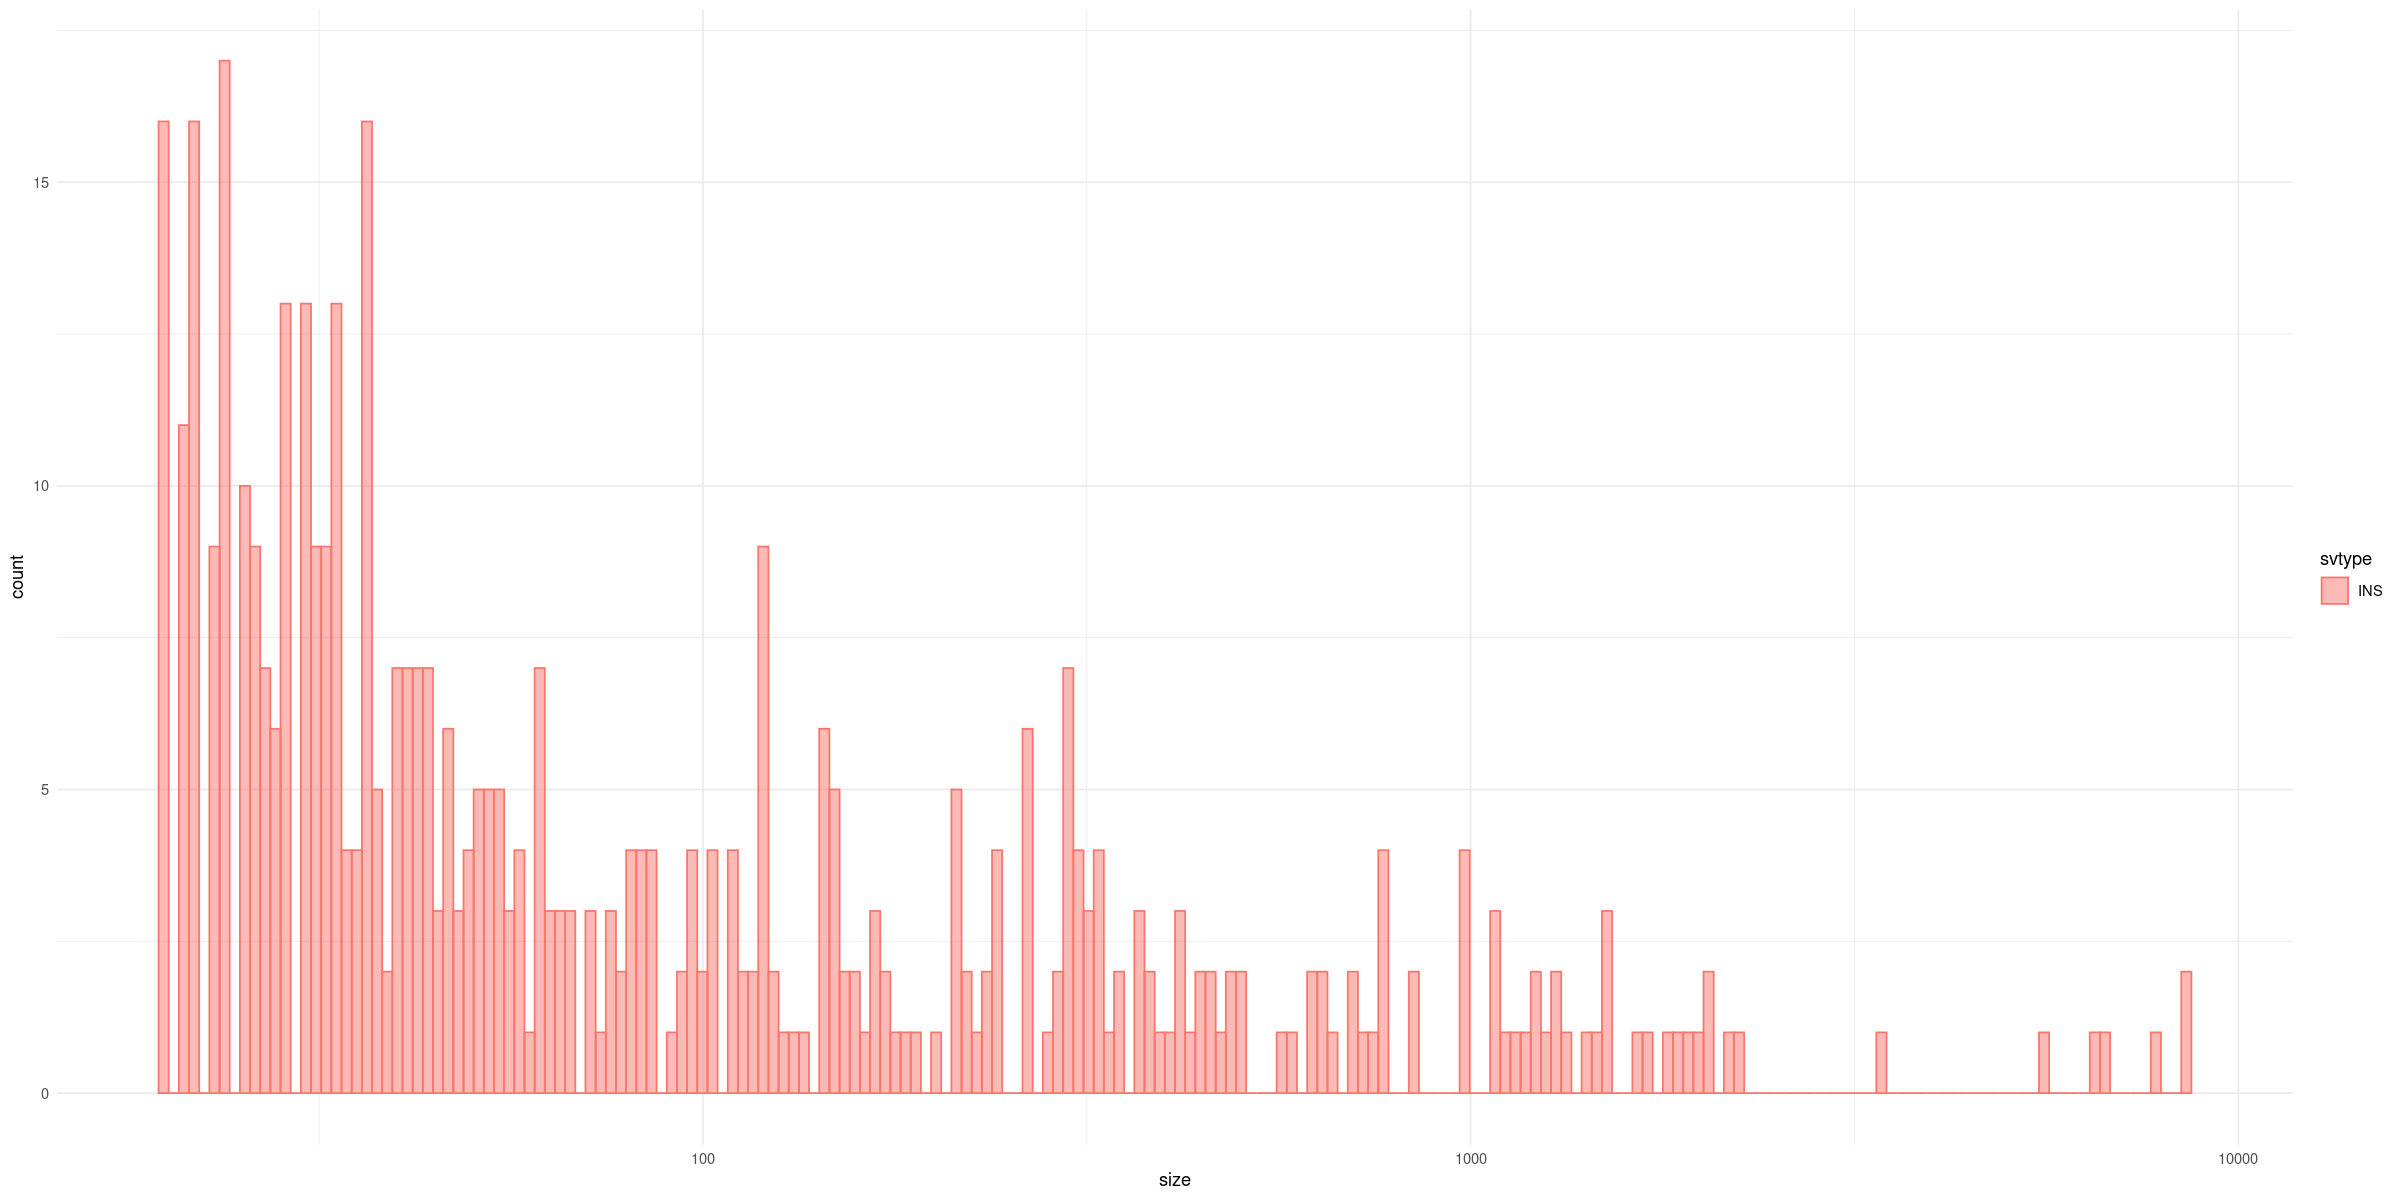

In [16]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(df, aes(x=size, fill=svtype, col=svtype)) +
  theme_minimal() +
  scale_x_continuous(trans = 'log10') + 
  geom_histogram(bins=200, position="identity", alpha=0.5) +
  theme_minimal()

#### Reading directly from the vcf file

In [ ]:
vcffile="test.vcf.gz"
df=read_vcf(vcffile)

In [ ]:
g = dualplotmulti(df, adjust=3)
options(repr.plot.width = 18, repr.plot.height = 6)
plot_grid(g$left, g$right, align = "h", ncol = 2, rel_widths = c(28/60, 32/60))